# Drive & Environment Setup

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, silhouette_samples
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
#from functions.compressor import compress
from functions.compressor_param import compress_2
from functions.mapping import ind2sub, sub2ind3d
from functions.clustering_foo import K_Medoids_elbow_best_model, K_Means_elbow_best_model, agglomerative_elbow

import random
from collections import defaultdict

import time

print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-05-30 13:28:24.799580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


# Data Import

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')  
df_def = pd.read_csv(cta30_def_path)


cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
cta30_21_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
cta30_22_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')

df18= pd.read_csv(cta30_18_path)
df19= pd.read_csv(cta30_19_path)
df20= pd.read_csv(cta30_20_path)
df21= pd.read_csv(cta30_21_path)
df22= pd.read_csv(cta30_22_path)

df = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

[r,c] = df.shape
print("The dataset has", r, "rows and", c, "columns")

The dataset has 2176378 rows and 76 columns


# Data Preprocessing - "Compression"

## Normalization

In [3]:
scale_norm = MinMaxScaler()
df_norm = pd.DataFrame(scale_norm.fit_transform(df), columns=df.columns)

## Standardization

In [4]:
st_scale = StandardScaler()
df_st = pd.DataFrame(st_scale.fit_transform(df), columns=df.columns)

# Data Preprocessing - "Clustering"

## K-Means

KMeans with 2 clusters computed in 33.6748731136322 seconds
KMeans with 3 clusters computed in 36.137765884399414 seconds
KMeans with 4 clusters computed in 44.82934021949768 seconds
KMeans with 5 clusters computed in 51.52250409126282 seconds
KMeans with 6 clusters computed in 58.89072895050049 seconds
KMeans with 7 clusters computed in 66.64799880981445 seconds
KMeans with 8 clusters computed in 74.44184303283691 seconds
KMeans with 9 clusters computed in 96.17185997962952 seconds
KMeans with 10 clusters computed in 104.69086194038391 seconds
KMeans with 11 clusters computed in 114.62688899040222 seconds


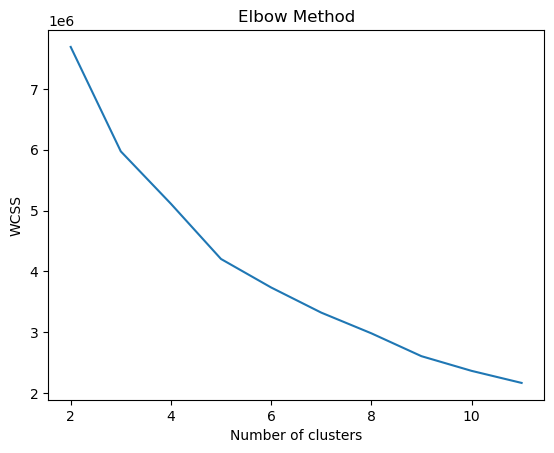

KMeans with 2 clusters computed in 48.663907051086426 seconds
KMeans with 3 clusters computed in 55.5534451007843 seconds
KMeans with 4 clusters computed in 64.79364109039307 seconds
KMeans with 5 clusters computed in 85.00805401802063 seconds
KMeans with 6 clusters computed in 82.33079504966736 seconds
KMeans with 7 clusters computed in 82.75911903381348 seconds
KMeans with 8 clusters computed in 86.53681683540344 seconds
KMeans with 9 clusters computed in 105.12513279914856 seconds
KMeans with 10 clusters computed in 127.26290678977966 seconds
KMeans with 11 clusters computed in 138.0138077735901 seconds


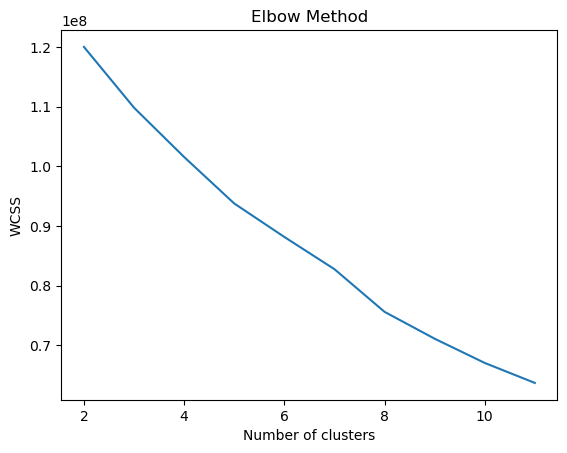

In [5]:
k_max = 11
w_norm = K_Means_elbow_best_model(df_norm, k_max)
w_st = K_Means_elbow_best_model(df_st, k_max)


Slopes of normalized data: [-858401.0038572159, -287033.3913209376, -226848.53595919302, -93647.28475752166, -68869.58689053862, -48574.93160699401, -47001.36330589681, -26788.1960116779, -19857.449507864938]
Slopes of standardized data: [-5094666.908643514, -2754934.106125464, -1946627.5244170465, -1121776.1335900724, -899996.9277129546, -1021196.2175429676, -562969.5105844159, -451233.80744914047, -334858.48092108517]


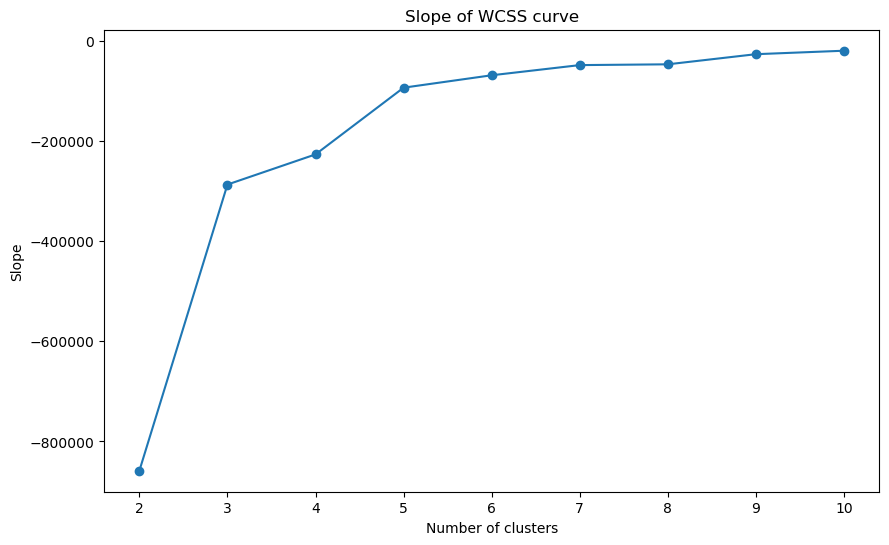

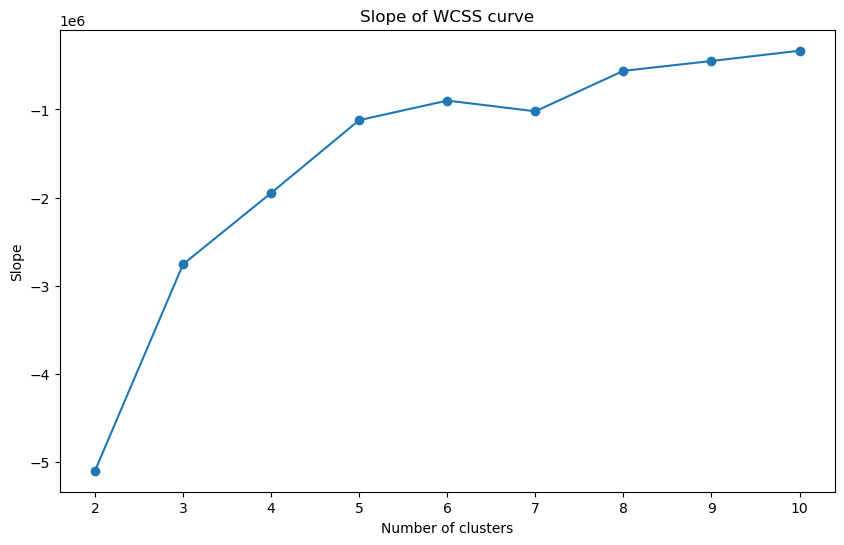

In [24]:
#calcola la pendenza dei segmenti della curva definita da wcss

def slope(wcss):
    slopes = []
    for i in range(1,len(wcss)):
        slopes.append((wcss[i]-wcss[i-1])/(i+1))
    return slopes

slopes_norm = slope(w_norm)
slopes_st = slope(w_st)

print("Slopes of normalized data:", slopes_norm)
print("Slopes of standardized data:", slopes_st)

#plot delle pendenze con bins e relativi punti

def plot_slopes(slopes, k_max=11):
    plt.figure(figsize=(10,6))
    plt.plot(range(2, k_max), slopes, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Slope')
    plt.title('Slope of WCSS curve')
    plt.show()

plot_slopes(slopes_norm, k_max)
plot_slopes(slopes_st, k_max)

In [17]:
a = [1,2,3,6,7,1,1]
b = a[:3]
b

[1, 2, 3]

## K-Medioids

In [ ]:
k_max = 3
K_Medoids_elbow_best_model(df_norm, k_max)
K_Medoids_elbow_best_model(df_st, k_max)


## Agglomerative

In [5]:
k_max = 3
agglomerative_elbow(df_norm, k_max)
agglomerative_elbow(df_st, k_max)

: 

## Gaussian Mixture

# Model Generation

## Clustering Generation

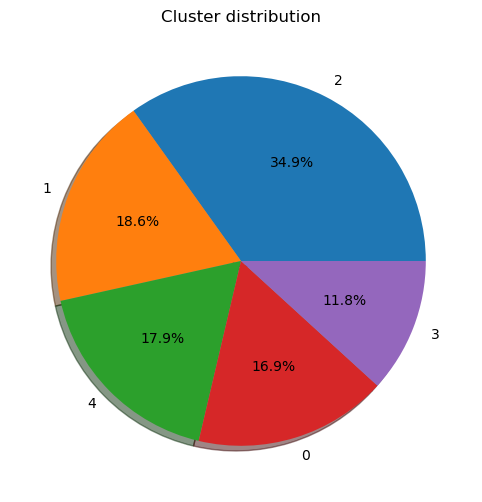

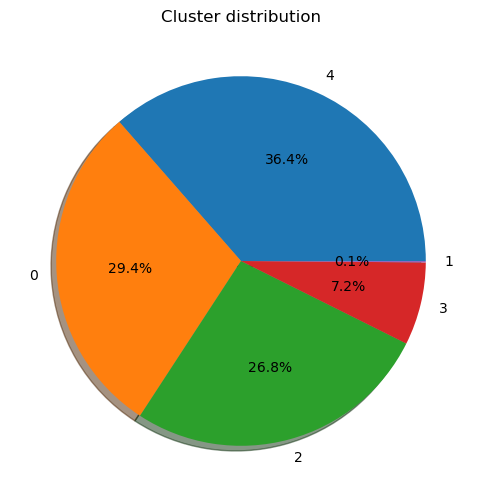

In [25]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_norm['cluster'] = kmeans.fit_predict(df_norm)

df_norm['cluster'].value_counts()

#pie graph of clusters
plt.figure(figsize=(10,6))
plt.pie(df_norm['cluster'].value_counts(), labels=df_norm['cluster'].value_counts().index, autopct='%1.1f%%', shadow=True)
plt.title('Cluster distribution')
plt.show()


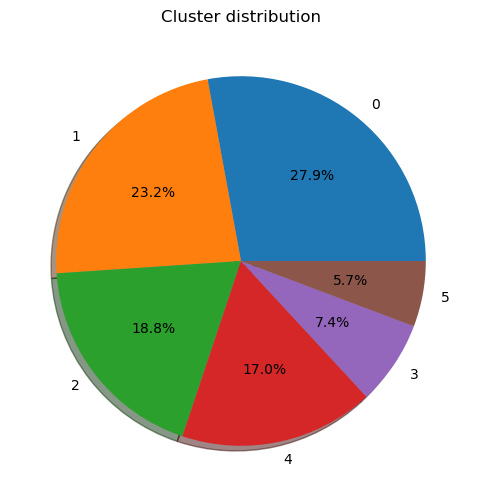

In [37]:

kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)

df_st['cluster'] = kmeans.fit_predict(df_st)

df_st['cluster'].value_counts()

#pie graph of clusters
plt.figure(figsize=(10,6))
plt.pie(df_st['cluster'].value_counts(), labels=df_st['cluster'].value_counts().index, autopct='%1.1f%%', shadow=True)
plt.title('Cluster distribution')
plt.show()


In [27]:
#save the clusters
df_norm.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clustered/kmeans_norm.csv'), index=False)
df_st.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clustered/kmeans_st.csv'), index=False)

## Actions Discretization

In [30]:
# Trova il valore più vicino dal basso per ogni azione
def valore_piu_vicino(lista, x):
    if x <= lista[0]:
        return lista[0]
    if x >= lista[-1]:
        return lista[-1]
    
    left = 0
    right = len(lista) - 1
    
    while left <= right:
        mid = (left + right) // 2
        
        if lista[mid] == x:
            return lista[mid]
        elif lista[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    
    if abs(lista[left] - x) < abs(lista[right] - x):
        return lista[left]
    else:
        return lista[right]
    

# Aggiungi un ultimo step agli intervalli di discretizzazione, così da considerare il valore massimo
def discretize_actions(min_value, max_value, num, upper):
    ret = np.linspace(min_value, max_value, num=num)
    if upper == True:
        step = ret[1] - ret[0]
        # add to last element step + ret[-1]
        ret = np.append(ret, step + ret[-1])
    return ret


[S, features] = df.shape

n_a1 = 15
n_a2 = 9
n_a3 = 9

a1_intervals = discretize_actions(df['F_M_FDBK_00'].min(), df['F_M_FDBK_00'].max(), num=n_a1, upper=True)
a2_intervals = discretize_actions(0, 1, num=n_a2, upper=True)
a3_intervals = discretize_actions(0, 1, num=n_a3, upper=True)
a1_intervals_list = a1_intervals.tolist()
a2_intervals_list = a2_intervals.tolist()
a3_intervals_list = a3_intervals.tolist()

a1_intervals = [round(num, 4) for num in a1_intervals_list]
a2_intervals = [round(num, 4) for num in a2_intervals_list]
a3_intervals = [round(num, 4) for num in a3_intervals_list]

for i in range(S):
    ret1 = valore_piu_vicino(a1_intervals, df.loc[i,'F_M_FDBK_00'])
    df.loc[i,'a1_discrete'] = ret1

    ret2 = valore_piu_vicino(a2_intervals, df.loc[i,'VLV_RAF_REG_00'])
    df.loc[i,'a2_discrete'] = ret2

    ret3 = valore_piu_vicino(a3_intervals, df.loc[i,'VLV_SUR_REG_00'])
    df.loc[i,'a3_discrete'] = ret3




KeyboardInterrupt: 

In [31]:
cta_partitioned = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv')  
df_part = pd.read_csv(cta_partitioned)

df_norm['a1_discrete'] = df_part['a1_discrete']
df_norm['a2_discrete'] = df_part['a2_discrete']
df_norm['a3_discrete'] = df_part['a3_discrete']

df_st['a1_discrete'] = df_part['a1_discrete']
df_st['a2_discrete'] = df_part['a2_discrete']
df_st['a3_discrete'] = df_part['a3_discrete']

n_a1 = 15
n_a2 = 9
n_a3 = 9


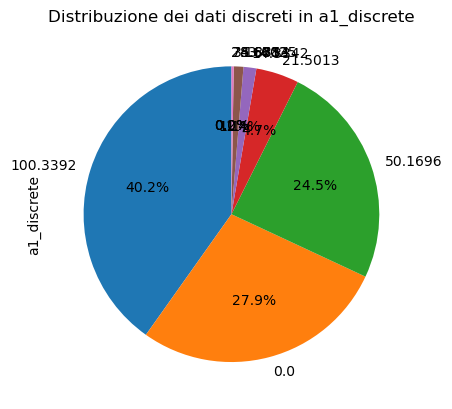

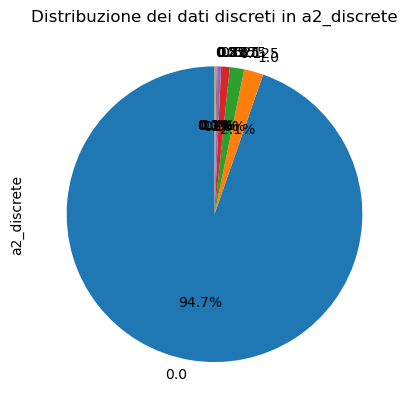

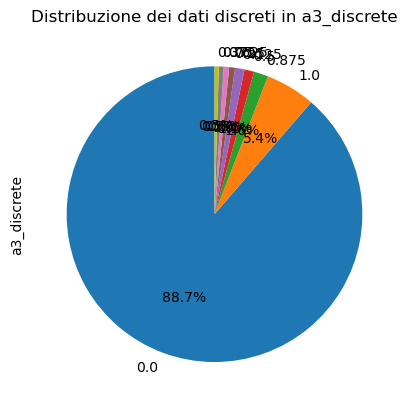

In [35]:
# Dati per il grafico a torta
labels = df_part['a1_discrete'].unique()
sizes = df_part['a1_discrete'].value_counts()

# Crea il grafico a torta
ax = sizes.plot.pie(labels=labels, autopct='%1.1f%%', startangle=90)

# Aggiunge un titolo al grafico
ax.set_title("Distribuzione dei dati discreti in a1_discrete")

# Mostra il grafico
plt.show()

# Dati per il grafico a torta
labels = df_part['a2_discrete'].unique()
sizes = df_part['a2_discrete'].value_counts()

# Crea il grafico a torta
ax = sizes.plot.pie(labels=labels, autopct='%1.1f%%', startangle=90)

# Aggiunge un titolo al grafico
ax.set_title("Distribuzione dei dati discreti in a2_discrete")

# Mostra il grafico
plt.show()

# Dati per il grafico a torta
labels = df_part['a3_discrete'].unique()
sizes = df_part['a3_discrete'].value_counts()

# Crea il grafico a torta
ax = sizes.plot.pie(labels=labels, autopct='%1.1f%%', startangle=90)

# Aggiunge un titolo al grafico
ax.set_title("Distribuzione dei dati discreti in a3_discrete")

# Mostra il grafico
plt.show()


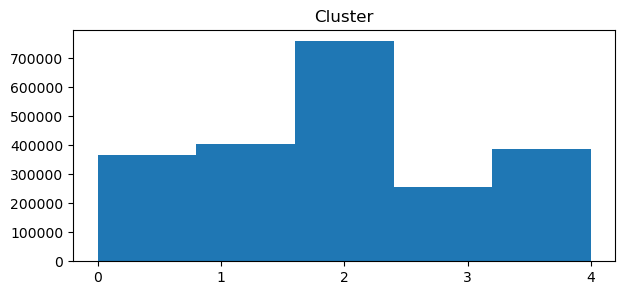

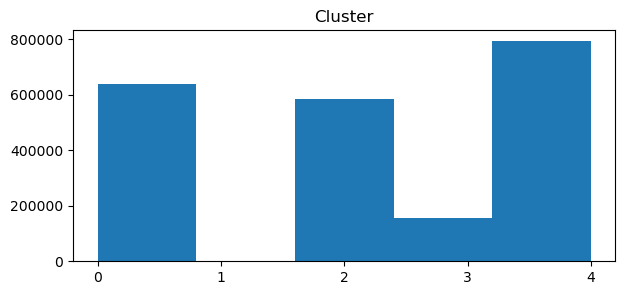

In [36]:
frequenze = df_norm['cluster'].value_counts().values
etichette = df_norm['cluster'].value_counts().index

# Crea il grafico a torta
plt.figure(figsize=(7,3))
plt.hist(etichette, bins=5, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster")
plt.show()

frequenze = df_st['cluster'].value_counts().values
etichette = df_st['cluster'].value_counts().index

# Crea il grafico a torta
plt.figure(figsize=(7,3))
plt.hist(etichette, bins=5, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster")
plt.show()

## Matrice di Transizione

In [42]:
a1_intervals = discretize_actions(df['F_M_FDBK_00'].min(), df['F_M_FDBK_00'].max(), num=n_a1, upper=True)
a2_intervals = discretize_actions(0, 1, num=n_a2, upper=True)
a3_intervals = discretize_actions(0, 1, num=n_a3, upper=True)
a1_intervals_list = a1_intervals.tolist()
a2_intervals_list = a2_intervals.tolist()
a3_intervals_list = a3_intervals.tolist()

a1_intervals = [round(num, 4) for num in a1_intervals_list]
a2_intervals = [round(num, 4) for num in a2_intervals_list]
a3_intervals = [round(num, 4) for num in a3_intervals_list]

print("a1_intervals:", a1_intervals)
print("a2_intervals:", a2_intervals)
print("a3_intervals:", a3_intervals)

a1_intervals: [0.0, 7.1671, 14.3342, 21.5013, 28.6683, 35.8354, 43.0025, 50.1696, 57.3367, 64.5038, 71.6709, 78.8379, 86.005, 93.1721, 100.3392, 107.5063]
a2_intervals: [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125]
a3_intervals: [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125]


### T norm

In [49]:
## NUOVO TENTATIVO

n_A = n_a1 * n_a2 * n_a3
[S, features] = df.shape

n_cluster = df_norm['cluster'].max() + 1
T = np.zeros((n_cluster, n_cluster, n_A))

for s in range(S):

    s_cluster = df_norm.loc[s, 'cluster']
    if s != S-1:
        s_prime = s + 1
    else:
        break
    
    
    s_cluster_prime = df_norm.loc[s_prime-1, 'cluster']
    
    a_dis = [df_norm.loc[s, 'a1_discrete'], df_norm.loc[s, 'a2_discrete'], df_norm.loc[s, 'a3_discrete']]
    a1_index = a1_intervals.index(a_dis[0])
    a2_index = a2_intervals.index(a_dis[1])
    a3_index = a3_intervals.index(a_dis[2])
    a_coord = [a1_index, a2_index, a3_index]
    a = sub2ind3d((n_a1, n_a2, n_a3), a_coord)
    T[int(s_cluster), int(df_norm.loc[s_prime, 'cluster']), int(a)] += 1


for a in range(n_A):
    sum_a = T[:, :, a].sum(axis=1)
    T[:, :, a] = T[:, :, a] / np.maximum(sum_a, 1e-6)[:, np.newaxis]#T[:, :, a].sum(axis=1)[:, np.newaxis]
    if np.isnan(T).any() == True:
        print("T contiene dei nan")

#check if there is a nan in T
print("T sum: ", T.sum())
print("T nan: ", np.isnan(T).any())
print("T inf: ", np.isinf(T).any())
print("T max: ", np.max(T))


# Specifica il nome della directory cluster_model
cluster_model = 'cluster_df_norm'

# Crea il percorso completo per la directory cluster_model
cluster_model_directory = os.path.join(PROJECT_PATH, 'MDP_data', cluster_model)

# Crea la directory cluster_model se non esiste
if not os.path.exists(cluster_model_directory):
    os.makedirs(cluster_model_directory)
    print("Directory", cluster_model, "creata con successo!")

# Salvataggio dell'array T nella directory cluster_model
T_file_path = os.path.join(cluster_model_directory, 'T_' + cluster_model + '.npy')
np.save(T_file_path, T)
    



T sum:  301.0
T nan:  False
T inf:  False
T max:  1.0
Directory cluster_df_norm creata con successo!


### T st

In [50]:
## NUOVO TENTATIVO

n_A = n_a1 * n_a2 * n_a3
[S, features] = df.shape

n_cluster = df_st['cluster'].max() + 1
print("n_cluster:", n_cluster)
T = np.zeros((n_cluster, n_cluster, n_A))

for s in range(S):

    s_cluster = df_st.loc[s, 'cluster']
    if s != S-1:
        s_prime = s + 1
    else:
        break
    
    
    s_cluster_prime = df_st.loc[s_prime-1, 'cluster']
    
    a_dis = [df_st.loc[s, 'a1_discrete'], df_st.loc[s, 'a2_discrete'], df_st.loc[s, 'a3_discrete']]
    a1_index = a1_intervals.index(a_dis[0])
    a2_index = a2_intervals.index(a_dis[1])
    a3_index = a3_intervals.index(a_dis[2])
    a_coord = [a1_index, a2_index, a3_index]
    a = sub2ind3d((n_a1, n_a2, n_a3), a_coord)
    T[int(s_cluster), int(df_st.loc[s_prime, 'cluster']), int(a)] += 1


for a in range(n_A):
    sum_a = T[:, :, a].sum(axis=1)
    T[:, :, a] = T[:, :, a] / np.maximum(sum_a, 1e-6)[:, np.newaxis]#T[:, :, a].sum(axis=1)[:, np.newaxis]
    if np.isnan(T).any() == True:
        print("T contiene dei nan")

#check if there is a nan in T
print("T sum: ", T.sum())
print("T nan: ", np.isnan(T).any())
print("T inf: ", np.isinf(T).any())
print("T max: ", np.max(T))


# Specifica il nome della directory cluster_model
cluster_model = 'cluster_df_st'

# Crea il percorso completo per la directory cluster_model
cluster_model_directory = os.path.join(PROJECT_PATH, 'MDP_data', cluster_model)

# Crea la directory cluster_model se non esiste
if not os.path.exists(cluster_model_directory):
    os.makedirs(cluster_model_directory)
    print("Directory", cluster_model, "creata con successo!")

# Salvataggio dell'array T nella directory cluster_model
T_file_path = os.path.join(cluster_model_directory, 'T_' + cluster_model + '.npy')
np.save(T_file_path, T)
    

n_cluster: 6
T sum:  155.0
T nan:  False
T inf:  False
T max:  1.0
Directory cluster_df_st creata con successo!


### R norm

In [55]:
dfx = df_norm.copy()
n_clusters = dfx['cluster'].max() + 1
mean_reward = np.zeros(n_clusters)
R = np.zeros((n_clusters, n_A))

for i in range(n_clusters):
    mean_reward = dfx[dfx['cluster'] == i]['PW_ATT_M_00'].mean()
    for j in range(n_A):
        R[i,j] = -mean_reward

cluster_model = 'kmeans'

# Crea il percorso completo per la directory cluster_model
cluster_model_directory = os.path.join(PROJECT_PATH, 'MDP_data', cluster_model)

# Crea la directory cluster_model se non esiste
if not os.path.exists(cluster_model_directory):
    os.makedirs(cluster_model_directory)
    print("Directory", cluster_model, "creata con successo!")

# Salvataggio dell'array T nella directory cluster_model
R_file_path = os.path.join(cluster_model_directory, 'R_norm_kmeans.npy')
np.save(R_file_path, R)


Directory kmeans creata con successo!


In [ ]:

n_clusters = dfx['cluster'].max() + 1
R = np.zeros((n_cluster, n_A))
mr = np.load(os.path.join(PROJECT_PATH, 'MDP_data',  cluster_model, 'mr_' + cluster_model + '.npy'))

for i in range(n_cluster):
    for j in range(n_A):

        R[i,j] = -mr[i]

# save R as array on npy file calling R + cluster name
cluster_model = R_norm

# Crea il percorso completo per la directory cluster_model
cluster_model_directory = os.path.join(PROJECT_PATH, 'MDP_data', cluster_model)

# Crea la directory cluster_model se non esiste
if not os.path.exists(cluster_model_directory):
    os.makedirs(cluster_model_directory)
    print("Directory", cluster_model, "creata con successo!")

# Salvataggio dell'array T nella directory cluster_model
R_file_path = os.path.join(cluster_model_directory, 'R_' + cluster_model + '.npy')
np.save(R_file_path, R)

### R st

In [56]:
dfx = df_st.copy()
n_clusters = dfx['cluster'].max() + 1
mean_reward = np.zeros(n_clusters)
R = np.zeros((n_clusters, n_A))

for i in range(n_clusters):
    mean_reward = dfx[dfx['cluster'] == i]['PW_ATT_M_00'].mean()
    for j in range(n_A):
        R[i,j] = -mean_reward

cluster_model = 'kmeans'

# Crea il percorso completo per la directory cluster_model
cluster_model_directory = os.path.join(PROJECT_PATH, 'MDP_data', cluster_model)

# Crea la directory cluster_model se non esiste
if not os.path.exists(cluster_model_directory):
    os.makedirs(cluster_model_directory)
    print("Directory", cluster_model, "creata con successo!")

# Salvataggio dell'array T nella directory cluster_model
R_file_path = os.path.join(cluster_model_directory, 'R_st_kmeans6.npy')
np.save(R_file_path, R)